# Energy and Buildings Paper V4

### Functions
All the subcomponents of the model
* Commerially Available Power Station
* Con Ed Network Data
* PV Performance Modeling
* Grid Electricity Costs
* Hardware Costs
* Max Automated DR Participation

### Loop
Generating all the hardware variations

### Filtering
Filtering hardware variations based on
* ROI

### Analysis

## To Do
* use an average of consumer prices
* add self consumption DC energy for controller to model
* confirm when inflation needs to be included

In [1]:
import pandas as pd
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime

In [2]:
#GLOBALS

lat = 40.7128
long = -74.0060

#optimize for summer when DR program is in effect
#also minimizes shading from buildings during PSH
tilt = math.floor(lat - 15)

#default to south facing
azimuth = 180

#14% losses
shading = .86

#max 99% efficient mppt battery charger
mppt = .99

#max 80% depth of discharge for LiFePO4 batteries
LiFePOdod = .8

NREL_API_KEY = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'

#Max Hardware Sizes
#500 is an estimate for the largest array someone can relatively easily install without a professional
pvMaxW = 500
#2kWh is the largest system FDNY allows without additional beurocracy 
batMaxWh = 2000

#PV degredation rate is assumed to be 1% annually
DEG_RATE = 0.01

## Commercially Available Power Station Data


In [3]:
# read in hardware data to dataframe
#hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV19.csv')

hardware_df = pd.read_csv('data/PowerStations_LiFePo4_Jan26.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Battery Type','App Control','Bypass Mode','Min PV Voltage','Max PV Voltage','Max AC Input Amps'
                                        , 'Warranty Years','Lifespan','Notes','Real Minimum Grid Charge Efficiency','Estimated Minimum Grid Charge Efficiency'])

retailPriceColumns = ['Retail Price (11/12/2023)','Retail Price (12/30/2023)','Retail Price (1/11/2024)','Retail Price (1/26/2024)']

#filter out batteries over specified size
#print(hardware_df[hardware_df['Battery Wh'] > 2000])
#hardware_df = hardware_df[hardware_df['Battery Wh'] <= 2000]

hardware_df.head()

,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,AC Charger Watts,Inverter Efficiency,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Unregulated Output,Cycles,DoD
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,5.0,300,100.0,2.00,NaN,1200.0,85.0,254.0,299.99,299.99,NaN,299.99,False,3000,80
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,11.0,1000,1800.0,1.75,NaN,NaN,85.0,399.0,799.00,799.00,NaN,799.00,False,4000,70
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,22.0,2000,1800.0,1.70,NaN,NaN,85.0,899.0,1199.00,1199.00,NaN,1199.00,False,4000,70
3,Jackery,Explorer 2000 Plus,2042.80,1400,0.685334,24.0,3000,1800.0,2.00,NaN,NaN,85.0,1659.0,2199.00,2199.00,NaN,2199.00,False,4000,70
4,Pecron,E600LFP,614.00,400,0.651466,7.0,1200,NaN,2.20,NaN,NaN,85.0,299.0,499.00,299.00,NaN,329.00,False,3500,80


In [4]:
#get average retail prices
hardware_df['avg retail price']= hardware_df[retailPriceColumns].mean(axis=1)
hardware_df.head()

,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,...,Inverter Efficiency,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Unregulated Output,Cycles,DoD,avg retail price
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,5.0,300,100.0,2.00,NaN,...,85.0,254.0,299.99,299.99,NaN,299.99,False,3000,80,284.660000
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,11.0,1000,1800.0,1.75,NaN,...,85.0,399.0,799.00,799.00,NaN,799.00,False,4000,70,665.666667
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,22.0,2000,1800.0,1.70,NaN,...,85.0,899.0,1199.00,1199.00,NaN,1199.00,False,4000,70,1099.000000
3,Jackery,Explorer 2000 Plus,2042.80,1400,0.685334,24.0,3000,1800.0,2.00,NaN,...,85.0,1659.0,2199.00,2199.00,NaN,2199.00,False,4000,70,2019.000000
4,Pecron,E600LFP,614.00,400,0.651466,7.0,1200,NaN,2.20,NaN,...,85.0,299.0,499.00,299.00,NaN,329.00,False,3500,80,309.000000


In [5]:
#display(hardware_df.tail())

#get average charge time percent for 80% relative to a 100% charge
hardware_df['charge ratio']= hardware_df['80 Per Grid Charge Hours']/hardware_df['Full Grid Charge Hours']

#display(hardware_df[~hardware_df['charge ratio'].isnull()]['charge ratio'])
#get the average ratio of 80% to 100% 
eightyCT = round(hardware_df[~hardware_df['charge ratio'].isnull()]['charge ratio'].mean()*100,2)*.01
print(str(eightyCT*100) + '% of the full charge time is spent charging from 0-80%.')
# #display(hardware_df.tail())

#update full charge column
hardware_df['Full Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] = hardware_df['80 Per Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] / eightyCT

#update 80% charge column
hardware_df['80 Per Grid Charge Hours'].loc[hardware_df['80 Per Grid Charge Hours'].isnull()] = hardware_df['Full Grid Charge Hours'].loc[hardware_df['80 Per Grid Charge Hours'].isnull()] * eightyCT

display(hardware_df.tail())

58.78% of the full charge time is spent charging from 0-80%.


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,...,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Unregulated Output,Cycles,DoD,avg retail price,charge ratio
58,OUKITEL,CN505,615.0,100,0.162602,3.0,500,NaN,7.000000,4.114600,...,269.0,599.0,NaN,NaN,NaN,False,2000,80,269.0,NaN
59,OUKITEL,P1201,960.0,500,0.520833,15.0,1200,700.0,2.551888,1.500000,...,499.0,799.0,439.0,NaN,439.0,False,3500,80,459.0,NaN
60,OUKITEL,P2001,2000.0,500,0.250000,15.0,2000,1100.0,3.062266,1.800000,...,899.0,1299.0,899.0,NaN,899.0,False,3500,80,899.0,NaN
61,OUKITEL,BP2000,2048.0,1000,0.488281,15.0,2200,1800.0,2.551888,1.500000,...,NaN,NaN,NaN,1699.0,1699.0,False,3500,80,1699.0,NaN
62,Zendure,SuperBase Pro Power Station 1500,1440.0,600,0.416667,10.0,2000,1800.0,2.000000,1.066667,...,NaN,NaN,NaN,NaN,1699.0,False,3000,80,1699.0,0.533333


In [6]:
hardware_df.keys()

Index(['Make', 'Model', 'Battery Wh', 'Max PV Watts', 'W to Wh Ratio',
       'Max PV Amps', 'Inverter Watts', 'Max AC Input Watts',
       'Full Grid Charge Hours', '80 Per Grid Charge Hours',
       'AC Charger Watts', 'Inverter Efficiency', 'Retail Price (11/12/2023)',
       'Full Price (11/20/2023)', 'Retail Price (12/30/2023)',
       'Retail Price (1/11/2024)', 'Retail Price (1/26/2024)',
       'Unregulated Output', 'Cycles', 'DoD', 'avg retail price',
       'charge ratio'],
      dtype='object')

In [7]:
# data snapshot
tP = hardware_df.shape[0]
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(tP))

#hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')
print('')
print('*** Wh ***')
print('Min:' + str(min(hardware_df['Battery Wh'])))
print('Max:' + str(max(hardware_df['Battery Wh'])))
print('Median:' + str(hardware_df['Battery Wh'].median()))

print('')
print('*** W ***')
print('Min:' + str(min(hardware_df['Max PV Watts'])))
print('Max:' + str(max(hardware_df['Max PV Watts'])))
print('Median:' + str(hardware_df['Max PV Watts'].median()))

print('')
print('*** W/Wh ***')
print('Min:' + str(min(hardware_df['W to Wh Ratio'])))
print('Max:' + str(max(hardware_df['W to Wh Ratio'])))
print('Median:' + str(hardware_df['W to Wh Ratio'].median()))

print('')
print('***Avg Retail Price ***')
print('Min:' + str(min(hardware_df['avg retail price'])))
print('Max:' + str(max(hardware_df['avg retail price'])))
print('Median:' + str(hardware_df['avg retail price'].median()))

print('')
print('*** $/Wh Avg Retail Price ***')
DollarsWh = hardware_df['avg retail price']/hardware_df['Battery Wh']
print('Min:' + str(min(DollarsWh)))
print('Max:' + str(max(DollarsWh)))
print('Median:' + str(DollarsWh.median()))

print('')
print('*** Cycles ***')
print('Min:' + str(min(hardware_df['Cycles'])))
print('Max:' + str(max(hardware_df['Cycles'])))
print('Median:' + str(hardware_df['Cycles'].median()))

print('')
print('*** Inv Eff ***')
print('Min:' + str(min(hardware_df['Inverter Efficiency'])))
print('Max:' + str(max(hardware_df['Inverter Efficiency'])))
inverterEfficiencyMed = hardware_df['Inverter Efficiency'].median() * .01
inverterEfficiencyMin = min(hardware_df['Inverter Efficiency']) * 0.01
inverterEfficiencyMean = round(hardware_df['Inverter Efficiency'].mean() * .01,4)
print('Median:' + str(inverterEfficiencyMed))
print('Mean:' + str(inverterEfficiencyMean * .01))
defaultInverterEfficiency = inverterEfficiencyMean
print('Default Efficiency for use in model: ' + str(defaultInverterEfficiency))
print('% with unknown efficiency: ' + str(100*hardware_df[hardware_df['Inverter Efficiency'].isnull()].shape[0]/tP))

print('')
print('*** PV Charge Time (without losses) ***')
print('Min:' + str(min(hardware_df['Battery Wh']/(hardware_df['Max PV Watts']*.99))))
print('Max:' + str(max(hardware_df['Battery Wh']/(hardware_df['Max PV Watts']*.99))))
pvChargeMed = (hardware_df['Battery Wh']/(hardware_df['Max PV Watts']*.99)).median()
print('Median:' + str(pvChargeMed))

print('')
print('*** AC Full Charge Time ***')
print('Min:' + str(min(hardware_df['Full Grid Charge Hours'])))
print('Max:' + str(max(hardware_df['Full Grid Charge Hours'])))
acChargeMed = hardware_df['Full Grid Charge Hours'].median()
print('Median:' + str(acChargeMed))



Total Number of Companies: 17
Total Number of Products: 63

*** Wh ***
Min:99.9
Max:2560.0
Median:1210.0

*** W ***
Min:40
Max:2100
Median:400.0

*** W/Wh ***
Min:0.1291989664
Max:1.025390625
Median:0.3722084367

***Avg Retail Price ***
Min:149.0
Max:2299.0
Median:799.0

*** $/Wh Avg Retail Price ***
Min:0.4373983739837398
Max:1.5690653432588917
Median:0.7430167597765364

*** Cycles ***
Min:2000
Max:6000
Median:3500.0

*** Inv Eff ***
Min:80.0
Max:92.0
Median:0.9
Mean:0.008769
Default Efficiency for use in model: 0.8769
% with unknown efficiency: 23.80952380952381

*** PV Charge Time (without losses) ***
Min:0.9850889850889851
Max:7.818181818181818
Median:2.7138047138047137

*** AC Full Charge Time ***
Min:1.0
Max:8.0
Median:2.0


## Con Ed Network Data

In [8]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2024.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,16:00,20:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,2
4,bronx,southeast bronx,16:00,20:00,2


In [9]:
#returns the network info for a given network
#args: network name
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
#args: network name
def getDLRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
#args: network name
def getCSRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#args: network name
def getTotalRate(networkName):
    return getDLRPrate(networkName) + getCSRPrate(networkName)
    
#returns borough name
#args: network name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
#args: network name
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

## PV Performance Modeling

In [10]:
#get TMY via API
df_tmy, metadata = pvlib.iotools.get_psm3(
    latitude=lat, longitude=long,
    api_key=NREL_API_KEY,
    email='nathaa@rpi.edu',  # <-- any email works here fine
    names='tmy-2020')
#metadata

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\pvlib\iotools\psm3.py:364: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  'to hide this warning.', pvlibDeprecationWarning)


In [11]:
# make a Location object corresponding to this TMY
location = pvlib.location.Location(name='NYC',
                                   latitude=metadata['Latitude'],
                                   longitude=metadata['Longitude'])

location

Location: 
  name: NYC
  latitude: 40.73
  longitude: -74.02
  altitude: 0
  tz: UTC

In [12]:
#normalize all years to 2022
#remove timezone info #,tzinfo=None
df_tmy.index = df_tmy.index.map(lambda t: t.replace(year=2020))

#uncomment the 30 minute shifts if using data that is right-labeled at hourly intervals!
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = df_tmy.index #- pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
#solar_position.index += pd.Timedelta('30min')

solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-01-01 00:30:00-05:00,161.167644,161.167644,-71.167644,-71.167644,22.397593,-3.190860
2020-01-01 01:30:00-05:00,154.001161,154.001161,-64.001161,-64.001161,54.029306,-3.210673
2020-01-01 02:30:00-05:00,143.834623,143.834623,-53.834623,-53.834623,72.365773,-3.230477
2020-01-01 03:30:00-05:00,132.705852,132.705852,-42.705852,-42.705852,84.714658,-3.250272
2020-01-01 04:30:00-05:00,121.355180,121.355180,-31.355180,-31.355180,94.580427,-3.270057
...,...,...,...,...,...,...
2020-12-31 19:30:00-05:00,121.549755,121.549755,-31.549755,-31.549755,265.621718,-3.441097
2020-12-31 20:30:00-05:00,132.896245,132.896245,-42.896245,-42.896245,275.528481,-3.460697
2020-12-31 21:30:00-05:00,144.009842,144.009842,-54.009842,-54.009842,287.965009,-3.480288
2020-12-31 22:30:00-05:00,154.134861,154.134861,-64.134861,-64.134861,306.489310,-3.499870


In [13]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
parameters = all_parameters['open_rack_glass_polymer']

#args: tilt, azimuth
def getPOA(t,a):
    #fixed tilt POA
    df_poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=t,
        surface_azimuth=a,
        dni=df_tmy['DNI'],
        ghi=df_tmy['GHI'],
        dhi=df_tmy['DHI'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic')

    #print(df_poa.keys())
    return df_poa

#DC power going in to battery after accounting for shading and equipment derating
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html#
#args: power, temp coefficient, array nameplate watts
def getPowerYield(p,g,n):
    
    # note the "splat" operator "**" which expands the dictionary "parameters"
    # into a comma separated list of keyword arguments
    cell_temperature = pvlib.temperature.sapm_cell(
        p['poa_global'], df_tmy['Temperature'], df_tmy['Wind Speed'], **parameters)
    
    array_power = pd.DataFrame({
        'power': pvlib.pvsystem.pvwatts_dc(p['poa_global'], cell_temperature, n, g,temp_ref=25.0)
    })

    #yield is actual power going in to battery after losses
    array_power['yield'] = array_power['power'] * shading * mppt
    
    return array_power
    #array_power = pvlib.pvsystem.pvwatts_dc(df_poa['poa_global'], cell_temperature, n, g,temp_ref=25.0)

    #factor in 14% shading losses + 1% mppt losses
    #return array_power * shading * mppt

#convert DC to AC with PV Watts model
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.inverter.pvwatts.html#pvlib.inverter.pvwatts
#args: dc power input, inverter nameplate max AC output, nameplate efficiency
def getACoutput(dcP,maxACW,iE):
    #max dc input required - assuming the nameplate WAC with efficiency accounted for
    dcPMax = maxACW/iE
    #args: dc power input, max dc input capacity, inverter nameplate efficiency
    return pvlib.inverter.pvwatts(dcP, dcPMax,iE)

#returns the degraded power of the array for a given year
#args: PV watts, year, PV degradation rate
def getDegradedP(w,y,dR = DEG_RATE):
    d = 1 - dR
    return w*(d**y)

array_power_yield = getPowerYield(getPOA(tilt,azimuth),gamma_pdc, 100)
array_power_yield.head()

,power,yield
2020-01-01 00:30:00-05:00,0.0,0.0
2020-01-01 01:30:00-05:00,0.0,0.0
2020-01-01 02:30:00-05:00,0.0,0.0
2020-01-01 03:30:00-05:00,0.0,0.0
2020-01-01 04:30:00-05:00,0.0,0.0


In [14]:
# print(array_power_yield['power'].max())
# print(array_power_yield['yield'].max())
# #array_power_yield.iloc[2891]

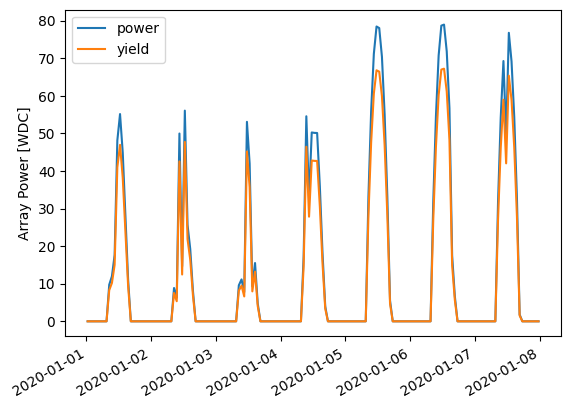

In [15]:
array_power_yield.head(24*7).plot()
plt.ylabel('Array Power [WDC]');

## Economic Modeling & Hardware Costs

Components:
* CAPEX
* grid electricity costs
* LCOSS

In [16]:
#average inflation rate, based on NREL data from https://atb.nrel.gov/electricity/2023/definitions#inflation
aIP = 2.5
aIR = aIP * .01

#returns inflation rate after Y years
#args: year
def infRate(y):
    return (1+aIR)**y

### Capital Expenses (CAPEX) i.e. upfront costs

In [17]:
# Upfront Costs

#args: pv watts
def getPVcost(w):
    #.7 is based on a 30% tax credit on PV modules
    taxCredit = .3
    #assumes $1 per W modules
    modulePerW = 1.0

    return w * (1-taxCredit) * modulePerW

#this is the total initial expenditure
#args: pv watts, battery price
def getCAPEX(pvW,batPr):
    #total sales tax in NYC is 8.875%
    salesTax =  0.08875 
    
    #variable costs
    mountDollarPerW = .4
    cablePerFt = .77 #pos & neg cables 
    cableRunFt = 15 * 2

    #fixed costs
    insulation = 4.38
    smartController = 114.73
    operatingCosts = 0 #DR aggregation operator costs are not considered here. 
    fixedHardwareCosts = smartController + operatingCosts + insulation

    variableCosts = batPr + getPVcost(pvW) + (pvW * mountDollarPerW) + (cablePerFt * cableRunFt)

    return (fixedHardwareCosts + variableCosts) * (1 + salesTax)

#print(getCAPEX(100,200))


### Grid Electricity Costs

Must add in inflation over 10 years...

In [18]:
# GRID ELECTRICITY COSTS

# source: EIA Electric Power Month, November 2023
# https://www.eia.gov/electricity/monthly/current_month/november2023.pdf
#Average Price of Electricity to Ultimate Customers - Residential - NYS - Year to Date
#septAvgYTDCents = 22.16

#Monthly Average Retail Price of Electricity - Residential
#source: https://www.nyserda.ny.gov/Energy-Prices/Electricity/Monthly-Avg-Electricity-Residential
#2023 - January to Sept
monthlyResElecPricesCents = [23.57, 23.60,21.18,19.81,20.47,21.63,22.27,22.33,23.23]

#2022 November to December
monthlyResElecPricesCents22 = [23.3,23.7,22.8]

monthlyResElecPricesCents.extend(monthlyResElecPricesCents22)
#print(monthlyResElecPrices)

rollingAvgDollars =round((sum(monthlyResElecPricesCents)/len(monthlyResElecPricesCents))* .01,4) 
print('12 Month NYS Residential Retail Electricity Average: $' + str(rollingAvgDollars) + '/kWh')

#args: kWAC generated from PV, year from installation
def utilityCosts(gkWAC,y=0):
    
    #utility costs, with grid rate increasing with inflation
    #this was the old one!!! confirm that removing deg rate doesn't break anything
    #annualAvoidedCosts = (generatedkWAC*((1-DEG_RATE)**y)) * (rollingAvgDollars*infRate(y))
    annualElectCosts = gkWAC * (rollingAvgDollars*infRate(y))
    
    return annualElectCosts

print(utilityCosts(15,5))

12 Month NYS Residential Retail Electricity Average: $0.2232/kWh
3.7879546967578106


### Levelized Cost of Solar plus Storage (LCOSS)

In [19]:
#returns the dollar value of the module at the end of the system's working like
# factors inmodule degradation 
# args: PV watts nameplate,year
def getResidualValue(w,y):
     return getPVcost(getDegradedP(w,y))

#test
#getResidualValue(100, 7.5)

In [20]:
'''
Numerator = CAPEX + Depreciation Benefits + O&M + Cost of purchased electricity - RESIDUAL VALUE
Denomenator = ANNUAL PV WAC Electricity Yield to Grid + ELEC FROM GRID TO BATTERY AND BACK - SELF CONSUMPTION
'''

#args: value to be discounted, year
def discountIt(v, y):
    discountRate = 0.055
    return v/(1+discountRate)**y

# LEVELIZED COST OF SOLAR plus STORAGE
#pv nameplat watts, battery nameplate watt hours, capex, working years, annual PV yield kWAC (list), effective efficiency of inverter, opex, avg annual events
def getLCOSS(w, wH, cap,wY,aY,eE,oM=0,aE = 3):
    #default discount rate of 5.5%   
    #grid energy costs are based on the assumption that the battery is charged
    #from 20% to 100% before every DR event and that there are 14 events per year
    #this only considers CSRP events which average 3 per year, not DLRP events which average less than 1 a year
    annEv = aE * 4 #14 annual events
    bC = wH * LiFePOdod * annEv #annual battery capacity is the nameplate Wh * 80% depth of discharge * the number of events
    aW = bC * eE #Available Watts AC, assumes a 4 hour discharge rate
    pW = bC / .95 #assumes 95% efficient AC battery charging
    
    num = cap  #intialize numerator with CAPEX
    den = 0 #kW
    
    #get all sums
    for mY in range(math.floor(wY)):
        num += discountIt(oM,mY) #O&M
        num += discountIt(utilityCosts(pW*.001,mY),mY) #UTILITY COSTS are in kW
        den += discountIt(pW,mY) #PV kWAC degraded #confirm that this gets discounted
        den += discountIt(aY[mY],mY) #Stored Energy from the grid kWAC #confirm that this gest discounted
    
    #remaining months
    if wY < 10:
        rY = math.floor(wY)
        #round up to a full month
        remainingMonths = math.ceil((wY - math.floor(wY))*12)

        #this does NOT consider uneven power and capital flows over the course of the year
        for m in range(remainingMonths):
            num += discountIt(oM,mY)/12 #O&M
            num += discountIt(utilityCosts(pW,mY),mY)/12 #UTILITY COSTS
            den += discountIt(pW,mY)/12 #PV kWAC degraded
            den += discountIt(aY[rY],mY)/12 #Stored Energy from the grid kWAC #confirm that this gest discounted

  #subtract the value of the PV module at the end of the battery's life
    num -= getResidualValue(w,wY)
   
    return num/den

# #test
# ayT = [56.05835348289077, 55.497769948061865, 54.94279224858124, 54.39336432609544, 53.84943068283447,
#        53.31093637600613, 52.77782701224607,52.25004874212361, 51.72754825470238, 51.21027277215535]
# print("LCOSS: $" + str(getLCOSS(300, 500,1000,8.5, ayT,.9)) + "/per kWAC")

## Max Automated DR Participation

In [21]:
#Assumed to be 5W 24 hours a day
scW = 5
annualSelfConsumptionkW = scW * 24 * 365 * 0.001

### CSRP

In [22]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts AC
# i.e. it returns what can automatically be provided per hour for 4 hours during a event in a given month

#get the available hourly watts if the battery is fully depleted over 4 hours
#arg: battery Wh
def getFourHourW(bWh):
    return bWh * LiFePOdod * .25

### DOES degrade (yes), interest (no), or self-consumption (yes) come in to play here?

#returns a list with the maximum automated participation for each of the 5 months
#args: battery Wh, hourly PV W yield, inverter efficiency, start time, inverter max watts, self-consumption=0, year=0
def maxDRParticipationCSRP(batWh, pvWyield,iE,sT,iM,sC = 0, year=0):
    #divide by 4 to account for the 4-hour long event window
    #this assumes a full battery at the onset of the event
    #subtract self-consumption
    batteryACOutput = getACoutput(getFourHourW(batWh)-sC,iM,iE)
    
    runningTot = 0

    #days in the months May - September
    daysInMonth = [31,30,31,31,30]
    
    #returns average WAC generated for all window hours on a monthly basis
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    # do I need to consider leap years?
    elapsedDays = 121
    drEventWhAC_MonthlyAvg = []
    #loop through the months
    for m in range(len(daysInMonth)):
        #print(daysInMonth[m])
        drEventWhAC_DailyAvg = 0
        #loop through days in the month
        for d in range(elapsedDays, elapsedDays +  daysInMonth[m]):
            #print(d)
            drEventWhAC = 0
            #loop through the 4 hours during the event
            for e in range(sT,sT + 4):
                #PV Yield for 1 hour during the event window
                drHour = ((d-1)*24)+e
                #print(getACoutput(pvWyield[drHour],iM,iE))
                drEventWhAC += getACoutput(getDegradedP(pvWyield[drHour],year),iM,iE)
            #print(drEventWhAC)
            #get the average for the day
            drEventWhAC_DailyAvg += drEventWhAC * .25
        #print((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_MonthlyAvg.append((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_DailyAvg = 0
        elapsedDays += daysInMonth[m]
    
        #this is average to an hourly basis NOT the total production during the event
        #runningTot = runningTot + (drEventDCWh/4)
    
    numDays = 274-121
    #print(drEventWhAC_MonthlyAvg)
    return drEventWhAC_MonthlyAvg

#uncomment to test
maxDRParticipationCSRP(2000, array_power_yield['yield'], defaultInverterEfficiency,11,500,5)

[391.08592680775865,
 391.2623092328032,
 390.7587193213146,
 388.99546213274107,
 385.8613784179077]

### DLRP

In [23]:
#morning yeild for DLRP events
#this used for determining starting battery capacity, so should be returned DC with mppt losses
#returns average PV Wh yield DC that can be stored in the battery prior to a given time of the day in July
#use noon for contingency events and 2pm for immediate events
#args PV yield, event type, year for PV degradation
def morningYield(pvWyield, event='c',year=0):
    #contingency event
    t = 18
    if event == 'i':
        #immediate event
        t = 14

    #loop through 31 days in July
    days = 31
    startDay = 182
    dailyAvg = 0
    for d in range(startDay, startDay + days):
        #loop through hours in the day
        dailyPV = 0
        for e in range(0,t):
            #PV Yield for 1 hour during the event window
            myHour = ((d-1)*24)+e
            #print(getACoutput(pvWyield[drHour],iM,iE))
            dailyPV += getDegradedP(pvWyield[myHour],year)*.99
        dailyAvg += dailyPV
    
    return dailyAvg / days

morningYield(array_power_yield['yield'],'i')

342.06728220308537

In [24]:
#returns the DC Wh the battery charged up to in 2 hours of charging from the grid
#does not include the bottom 20%
def twoHourChargeWh(batWh,gridT):
    maxB = batWh * .8
    #time it takes to charge from 20% to 80% percent
    e = gridT * eightyCT * .75
    #print(e)
    t = gridT * (1-eightyCT)
    #print(t)
    #print(e+t)
    #if 80% is reached in under 2 hours
    if e < 2:
        #print('80 under 2')
        #prorate the top 20% and add 60% back in
        return min(maxB,(batWh * .2 * ((2-e)/t)) + (batWh * .6))
    else:
        #print('80 not under 2')
        #if 20%-80% isn't reached in 2 hours
        #prorate that chunk 
        return batWh * .6 * (2/e)
    
    #chargeAmt = min(1,2/(gridT*.8))

#returns a list with the maximum automated participation for each of the 5 months
#args: battery Wh, grid charge hours, hourly PV W yield, inverter efficiency, inverter max watts, self-consumption=0, year=0, event
def maxDRParticipationDLRP(batWh, gridT, pvWyield,iE,iM,sC = 0, year=0,event='c'):
    
    maxWh = getFourHourW(batWh)
    
    #get the available PV yield from the morning spread out over 4 hours of event time
    mY = morningYield(pvWyield, event,year)*.25
    
    #this assumes battery wasn't depleted below 20%
    if event == 'c':
        #DLRP assumes charged as much as possible in 2 hours. It doesn't assume a full battery.
        
        #if grid charge time > 2 hours
        if gridT > 2:
            availableWh = twoHourChargeWh(batWh,gridT) * 0.25
        else:
            availableWh = getFourHourW(batWh)        
        
        availableWh = min(maxWh, availableWh + (mY))
    else:
        #for immediate events with no time to charge the battery from the grid,
        #the available energy is based off of PV production from earlier in the day
        availableWh = min(maxWh, mY)
        
    #subtract self-consumption and account for inverter losses
    batteryACOutput = getACoutput(availableWh-sC,iM,iE)

    drEventWhAC_MonthlyAvg = []
    for m in range(5):
          drEventWhAC_MonthlyAvg.append(batteryACOutput)

    return drEventWhAC_MonthlyAvg

maxDRParticipationDLRP(3000, 3, array_power_yield['yield'], defaultInverterEfficiency,500,5,10,'c')

[499.99999999999994,
 499.99999999999994,
 499.99999999999994,
 499.99999999999994,
 499.99999999999994]

In [25]:
# $1/kWh
#args: energy in Wh, average annual events
#returns dollar amount
def getPerformanceAmount(e, aaE=3):
    return e * 0.001 * aaE * 4

### ROI

In [26]:
#args: capex, annual avoided grid costs, monthly DR revenue, annual DR performance income, annual electricity costs
def getROI(c,g,dC,dD, p,eC):
    #get annual total economic benefit
    a = []
    for y in range(len(g)):
        a.append(g[y] + sum(dC[y]) + sum(dD[y]) + p[y])
    
    r = 0
    tI = 0
    
    #rolling total of electricity costs
    rollingElCo = 0
    
    #loop through 10 years and break the loop if the total income exceeds the CAPEX
    for y in range(1,11):
        rollingElCo += eC[y-1]
        if tI+a[y-1] >= c + rollingElCo:
            r = y-1
            break
        r = y
        tI += a[y-1]

    #determine when in the remaining year total income equals CAPEX,
    #consider that DR rates are different every month
    
    #remaining balance of CAPEX
    rtI = c + rollingElCo - tI
    
    #if our ROI is under 10 years, lets get specific
    if r < 10:
        #create a list of the total income for the remainder year by month
        mon = []
        for m in range(12):
            dr = 0
            if m >= 4 and m < 9:
                dr = dC[r][m-4] + dD[r][m-4]
            if m == 9: #add the DR performance payment at the end of the season
                dr = p[r]
            gm = g[r]/12
            mon.append(gm+dr)
        #print(mon)
        
        #print('LESS THAN OR EQUAL TO 10!')
        #print('simplified ROI: ' str(r + (rtI/a[r]))) #simplified without consider when DR occurs
        #revenue by month for remainder year
        rBM = 0
        month = 0
        for m in range(12):
            rBM += mon[m]
            if rtI <= rBM:
                month = m +1
                break
        r += month/12
                            
    #we're going to filter out ROIs over 10 years, so we just need a rough figure here to plot it later on
    #this doesn't include inflation and degradation past 10 years, nor differing monthly revenues
    else:
        #print('NOT LESS THAN 10!')
        #use max, incase the rough ROI ends up slightly less than 10
        r = max(10,r + (rtI/a[9]))

    return r

#UNCOMMENT TO TEST
##capex
#cT=1302.98635 + 6

# #annual avoided grid costs
#gT = [62.5611224869061, 63.502479696966574, 64.45800150896684, 65.42790105767229, 66.41239468488708,
#      67.41170198771056, 68.42604586751966, 69.45565257968823, 70.50075178405481, 71.56157659614948]

# #dr inc by month by year
# dT = [[15.202412956432898, 15.217837611568264, 15.174630518701857, 15.021859407269638, 14.746181494705318],
#  [15.16149258214941,  15.176799837319079,  15.134021505006283,  14.982848412258873,  14.709852237792287],
#  [15.120980546235673,  15.136171573187376,  15.093817756118627,  14.9442267175778,  14.673885565895645],
#  [15.080872782528917,  15.095948741337718,  15.054015235814862,  14.905990446334567,  14.638277867245522],
#  [15.041165265185306,  15.05612730436943,  15.014609947906358,  14.868135760085622,  14.60302556590956],
#  [15.001854008283555,  15.016703264919101,  14.975597935846036,  14.830658858457618,  14.568125121440094],
#  [14.962935065432404,  14.977672665266901,  14.936975282338325,  14.79355597877295,  14.533573028524778],
#  [14.924404529381864,  14.939031586946715,  14.89873810895291,  14.75682339567893,  14.499365816640598],
#  [14.886258531638225,  14.900776150360047,  14.860882575742178,  14.720492199543328,  14.465500049711213],
#  [14.848493242082782,  14.862902514393653,  14.82340488086241,  14.684524378331481,  14.431972325767637]]

#getROI(cT,gT,dT)

In [27]:
#args: roi, working life years, annual avoided grid costs, DR income by month
def getIAR(r,w,g,dC,dD):
    #get total monthly econ benefit
    #create a list of the total income for the remainder year by month
    rMonth = math.floor(r*12)
    eMonth = math.floor(w * 12)
#     print(rMonth)
#     print(eMonth)
    #get tot econ benefit by month
    mB = []
    for y in range(10):
        for m in range(12):
            dr = 0
            if m >= 4 and m < 9:
                dr = dC[y][m-4] + dD[y][m-4]
            gm = g[y]/12
            mB.append(gm+dr)
    
    i = 0
    for m in range(rMonth,eMonth):
        i += mB[m]
    
    return i

#uncomment to test
#getIAR(9.416666666666666,10,gT,dT)

In [28]:
#determines the financial importance of DR for the system to be financially viable in <= 10 years
#args: capex, annual avoided grid costs, lifespan rounded up to the nearest year
#returns the minimum amount of money needed to generate from DR in its lifetime
def requiredDRincome(c,g,l):
    t = 0
    for y in range(math.ceil(l)):
        #print(y)
        t += g[y]
        
        if t >= c:
            return 0
        
    return c - t

#UNCOMMENT TO TEST
# #capex
# cT=1302.98635 + 6

# #annual avoided grid costs
# gT = [62.5611224869061, 63.502479696966574, 64.45800150896684, 65.42790105767229, 66.41239468488708,
#      67.41170198771056, 68.42604586751966, 69.45565257968823, 70.50075178405481, 71.56157659614948]

#requiredDRincome(cT, gT,7.6)

## Main Loop

This loop generates all the possible combinations of hardware and their energy and economic characteristics based on the constraints of the battery. 

In [29]:
#these networks are selected because they represent all possible combinations of characteristics

#myNetworks2023 = ['city hall','long island city','crown heights','randalls island', 'millwood west', 'grasslands','fresh kills','central bronx','northeast bronx']

In [32]:

print('loop start time:')
print(datetime.now())

rData = {
        'network':[],
        'eventStart':[],
        'az':[],
        'pvW':[],
        'batWh':[],
        'gridChargeTime':[],
        'dischargeRateW':[],
        'capex':[],
        'dollarPerBatkWh':[],
        #'annualPVkWh':[],
        'annualPVkWhDC_degraded':[],
        #'annualPVkWhAC':[],
        'annualPVkWhAC_degraded':[],
        'avoidedGridCosts':[],
        'immediateEventAmt':[],
        'maxAutoParticipationMonthlyW_C':[],
        'maxAutoParticipationMonthlyW_D':[],
#         'maxAutoParticipationMonthlyW_degraded_C':[],
#         'maxAutoParticipationMonthlyW_degraded_D':[],
        'maxAutoParticipationW_C':[],
        'maxAutoParticipationW_D':[],
        #'maxAutoParticipationW_degraded':[],
        'avgMAPw_C':[], #averaged max auto participation W
        'avgMAPw_D':[], #averaged max auto participation W
        #'minParticipants':[],
        'totalDRratekW':[],
        #'drIncMonthly':[],
        'drIncMonthly_C':[],
        'drIncMonthly_D':[],

    #'drIncAnnual':[],
        'drIncAnnual_C':[],
        'drIncAnnual_D':[],

    #'annualIncome':[],
        'drPerformanceIncome':[],
    
        'minDRinc':[], #the minimum DR income required to economical
        'minDRkWperf':[], #the minimum DR performance required to be economical
    
        'annualIncome':[],
        'LCOSS':[],
        #'roi':[],#nominal rate of return
        'realRoi':[], #real rate of return includes inflation and PV degradation
        'Cycles':[],
        'lifespan':[],
        'workingLife':[],
        'profitableYears':[],
        'incomeAfterRoi':[],
        'iarSplit':[]
    }

#comment in to test quicker
#myNetworks = ['bowling green']
#these networks are selected because they represent all possible combinations of characteristics
myNetworks = ['bowling green','long island city','sunnyside','crown heights','grasslands','fresh kills','williamsburg','northeast bronx','ridgewood']

#loop through all networks
for n in myNetworks:
    print(n)
    
    #loop through all batteries in database
    #comment in/out to test
    #for b in [10]:
    for b in range(hardware_df.shape[0]):

        #get battery info
        d = hardware_df.iloc[b]
        #print(d)

        #if inverter efficiency data isn't available use minimum value
        if pd.isnull(d['Inverter Efficiency']):
            invEff = defaultInverterEfficiency
        else:
            invEff = d['Inverter Efficiency'] * .01

        bWh = d['Battery Wh']

        #time in hours it takes to charge the battery
        #from 0% to 100% from the grid
        bCT = d['Full Grid Charge Hours']
        
        #run this for a quicker test
        #for a in [180]:
        #loop through 3 azimuths
        for a in [110,180,250]:
            
            #immediate event frequency
            for i in [0,1,5]:
                #get plane of array irradiance for given azimuth
                poa = getPOA(tilt, a)

                #loop through all allowed PV modules sizes, from 40 to 500 (or max PV capacity if less), incrementing by 10
                for pW in range(40,min(500,d['Max PV Watts'])+10,10):
                    rData['network'].append(n)
                    rData['eventStart'].append(getStartTime(n))
                    rData['az'].append(a)

                    #PV Watts
                    rData['pvW'].append(pW)
                    #Battery Watt Hours
                    rData['batWh'].append(bWh)

                    rData['gridChargeTime'].append(bCT)

                    #Hardware Costs in Dollars
                    capex =getCAPEX(pW,d['avg retail price'])
                    rData['capex'].append(capex)
                    rData['dollarPerBatkWh'].append((capex/bWh)*.001)#this is to compare against NREL data in the discussion section

                    array_power_yield = getPowerYield(poa,gamma_pdc, pW)
                    #Sum total PV generation kWDC (1st year, no PV degradation)
                    pvkWhDC = array_power_yield['yield'].sum() * .001                    

                    #get lists of PV WDC yield with degredation
                    PVyDC = [pvkWhDC] #initialize with the year 1 undegraded generation
                    for y in range(1,10):
                        #annual self consumption accounts for the power draw of the control hardware
                        PVyDC.append(getDegradedP(pvkWhDC,y))
                    rData['annualPVkWhDC_degraded'].append(PVyDC)

                    #convert to AC
                    #assumes all PV gets utilized in battery and battery is depleted 80% at 4-hour rate
                    fH = getFourHourW(bWh)
                    rData['dischargeRateW'].append(fH)
                    #effective efficiency is the actualy efficiency when consuming power at the 4 hour rate
                    effectiveEfficiency = getACoutput(fH,d['Inverter Watts'],invEff)/fH

                    #subtract self-consumption from DC PV generation before converting
                    annPvkWhAC = []
                    for p in PVyDC:
                        annPvkWhAC.append((p - annualSelfConsumptionkW)* effectiveEfficiency)
                    #print(annPvkWhAC)
                    rData['annualPVkWhAC_degraded'].append(annPvkWhAC)

                    #total annual avoided grid consumption costs based on AC solar generation
                    #get lists of avoided grid costs with degredation, inflation, and self-consumption considerations
                    gC_dI=[]
                    for y in range(len(annPvkWhAC)):
                        gC_dI.append(utilityCosts(annPvkWhAC[y],y))
                    rData['avoidedGridCosts'].append(gC_dI)

                    # maximum possible automated hourly DR participation:
                    #the least automated participation at any point in the years is the MAX automation possible for that year
                    #Automated DR participation = PV WAC + 25% of available battery at event start - self-consumption

                    #get lists of CSRP DR participation rates with degredation
                    dr_C = []
                    for y in range(10):
                        #dr_d.append(utilityCosts(getDegradedP(annPvkWh,y))*1.025**y)
                        dr_C.append(maxDRParticipationCSRP(bWh,array_power_yield['yield'],invEff,getStartTime(n),d['Inverter Watts'],scW, y))
                    rData['maxAutoParticipationMonthlyW_C'].append(dr_C)

                    #get lists of DLRP DR participation rates with degredation
                    dr_D = []
                    rData['immediateEventAmt'].append(i)
                    for y in range(10):
                        #determine if its a contingency year or an emergency year
                        if i == 0:
                            eventType = 'c'
                        elif i == 1:
                            if y==0:
                                eventType ='i'
                            else:
                                eventType = 'c'
                        elif i == 5:
                            if y<5:
                                eventType ='i'
                            else:
                                eventType = 'c'
                                
                        dr_D.append(maxDRParticipationDLRP(bWh,bCT, array_power_yield['yield'],invEff,d['Inverter Watts'],scW, y,eventType))
                    rData['maxAutoParticipationMonthlyW_D'].append(dr_D)

                    #rData['maxAutoParticipationW'].append(min(maxParW))
                    mAP_C = []
                    for y in range(10):
                        mAP_C.append(min(dr_C[y]))
                    rData['maxAutoParticipationW_C'].append(mAP_C)

                    mAP_D = []
                    for y in range(10):
                        mAP_D.append(min(dr_D[y]))
                    rData['maxAutoParticipationW_D'].append(mAP_D)

                    rData['avgMAPw_C'].append(sum(mAP_C)/len(mAP_C))
                    rData['avgMAPw_D'].append(sum(mAP_D)/len(mAP_D))


                    #monthly income from DR participation
                    #the DR rate for each program
                    dDRrkW= getDLRPrate(n)
                    cDRrkW= getCSRPrate(n)

                    tDRrkW = dDRrkW + cDRrkW
                    rData['totalDRratekW'].append(tDRrkW)

                    #monthly income from DR
                    #monInc= [m * 0.001 * tDRrkW for m in maxParW]
                    #rData['drIncMonthly'].append(monInc)

                    drInc_C = []
                    drInc_D = []
                    for y in range(0,10):
                        drInc_C.append([m * 0.001 * cDRrkW for m in dr_C[y]])
                        drInc_D.append([m * 0.001 * dDRrkW for m in dr_D[y]])
                    rData['drIncMonthly_C'].append(drInc_C)
                    rData['drIncMonthly_D'].append(drInc_D)

                    #annual income from DR participation
                    #drAnnInc = sum(monInc)
                    #rData['drIncAnnual'].append(drAnnInc)

                    drAnnInc_C = []
                    for y in drInc_C:
                        drAnnInc_C.append(sum(y))
                    rData['drIncAnnual_C'].append(drAnnInc_C)

                    drAnnInc_D = []
                    for y in drInc_D:
                        drAnnInc_D.append(sum(y))
                    rData['drIncAnnual_D'].append(drAnnInc_D)

                    #this isn't factored in to monthly income.
                    #for the  purposes of this model, it is paid out after the DR season is over. i.e. in with September payments
                    drPer = []
                    for y in range(10):
                        #assumes 3 CSRP events per year and 0 DLRP events per year
                        drPer.append(getPerformanceAmount(mAP_C[y]))
                    rData['drPerformanceIncome'].append(drPer)

                    #total annual income
                    #annInc = aGC + drAnnInc
                    #rData['annualIncome'].append(annInc)

                    annInc = []
                    for y in range(10):
                        #add avoided  grid costs, reservation income from CSRP and DLRP, and CSRP performance income
                        annInc.append(gC_dI[y] + drAnnInc_C[y] + drAnnInc_D[y] + drPer[y])
                    rData['annualIncome'].append(annInc)

                    #simple ROI is (capex + expenses)/
                    
                    #assumes 95% efficient grid charging
                    annElecCosts = []
                    for y in range(10):
                        #assume average of 12 hours of events per year
                        annElecCosts.append(utilityCosts((bWh * 0.001 * LiFePOdod * 12) / .95,y))
                    
                    #real roi is more complex because income varies by year and month
                    rRoi = getROI(capex, gC_dI,drInc_C, drInc_D,drPer,annElecCosts)
                    rData['realRoi'].append(rRoi)

                    rData['Cycles'].append(d['Cycles'])
                    #life span assumes 1 full cycle a day
                    lS = d['Cycles']/365
                    rData['lifespan'].append(lS)
                    #working life caps the lifespan at 10 years
                    wL = min(10,lS)
                    rData['workingLife'].append(wL)
                    
                    #this is basically how much DR income is required to reach ROI within its lifespan
                    mDi = requiredDRincome(capex,gC_dI,wL)
                    rData['minDRinc'].append(mDi)
                    #this is a rough figure that only includes reservation rates only and ignores performance rates
                    #this could be more fine tuned by looking ratio of reservation to performance income...
                    mDp = mDi / getTotalRate(n) #total kWh over the lifetime
                    mDp = mDp / math.ceil(lS) / 5 #monthly kWh commitment
                    rData['minDRkWperf'].append(mDp)
                    
                    #pv W, battery Wh, capex, working years, annual PV yield kWAC (list), effective efficiency of inverter
                    rData['LCOSS'].append(getLCOSS(pW,bWh,capex,wL,annPvkWhAC,effectiveEfficiency))
                    #profitable years is the time between ROI and the end of working life
                    pY = max(0,wL - rRoi)
                    rData['profitableYears'].append(pY)
                    #income after ROI is the financial benefit during the profitable years
                    #iar = annInc * pY
                    iar = getIAR(rRoi, wL,gC_dI,drInc_C, drInc_D)
                    rData['incomeAfterRoi'].append(iar)
                    #IAR split across lifespan 
                    rData['iarSplit'].append(iar / wL)

print('loop end time:')
print(datetime.now())

    #load data into a DataFrame object:
results_df = pd.DataFrame(rData)
    #nData[n]=productTest_df
print(str(results_df.shape[0])+ ' total hardware combinations generated')

ts = datetime.now().timestamp()
results_df.to_csv('results/results_df_' + str(math.floor(ts)) +'.csv')

loop start time:
2024-01-27 22:17:27.154103
bowling green
long island city
sunnyside
crown heights
grasslands
fresh kills
williamsburg
northeast bronx
ridgewood
loop end time:
2024-01-28 06:17:32.268881
158679 total hardware combinations generated


In [33]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'gridChargeTime',
       'dischargeRateW', 'capex', 'dollarPerBatkWh', 'annualPVkWhDC_degraded',
       'annualPVkWhAC_degraded', 'avoidedGridCosts', 'immediateEventAmt',
       'maxAutoParticipationMonthlyW_C', 'maxAutoParticipationMonthlyW_D',
       'maxAutoParticipationW_C', 'maxAutoParticipationW_D', 'avgMAPw_C',
       'avgMAPw_D', 'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D',
       'drIncAnnual_C', 'drIncAnnual_D', 'drPerformanceIncome', 'minDRinc',
       'minDRkWperf', 'annualIncome', 'LCOSS', 'realRoi', 'Cycles', 'lifespan',
       'workingLife', 'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [34]:
# results_df['minDRkWperf']/results_df['realRoi'].head()
# results_df['minDRWperfH'] = (results_df['minDRkWperf']/results_df['realRoi']/5) * 1000

In [35]:
results_df.head()

,network,eventStart,az,pvW,batWh,gridChargeTime,dischargeRateW,capex,dollarPerBatkWh,annualPVkWhDC_degraded,...,minDRkWperf,annualIncome,LCOSS,realRoi,Cycles,lifespan,workingLife,profitableYears,incomeAfterRoi,iarSplit
0,bowling green,11,110,40,288.0,2.0,57.6,512.659713,0.001780,"[49.15755553736246, 48.66597998198884, 48.1793...",...,0.312609,"[10.768928186546251, 10.684480331876076, 10.59...",0.031259,52.089332,3000,8.219178,8.219178,0.0,0.0,0.0
1,bowling green,11,110,50,288.0,2.0,57.6,524.635963,0.001822,"[61.44694442170308, 60.83247497748605, 60.2241...",...,0.306496,"[13.447050371702087, 13.39253286911642, 13.335...",0.031429,41.117353,3000,8.219178,8.219178,0.0,0.0,0.0
2,bowling green,11,110,60,288.0,2.0,57.6,536.612213,0.001863,"[73.73633330604369, 72.99896997298325, 72.2689...",...,0.300383,"[16.125064390756886, 16.10048016363939, 16.074...",0.031598,34.259325,3000,8.219178,8.219178,0.0,0.0,0.0
3,bowling green,11,110,70,288.0,2.0,57.6,548.588463,0.001905,"[86.02572219038431, 85.16546496848046, 84.3138...",...,0.294269,"[18.802893024710247, 18.80824843437299, 18.812...",0.031766,29.566896,3000,8.219178,8.219178,0.0,0.0,0.0
4,bowling green,11,110,80,288.0,2.0,57.6,560.564713,0.001946,"[98.31511107472492, 97.33195996397768, 96.3586...",...,0.288156,"[21.4805356400861, 21.515834388298778, 21.5503...",0.031932,26.154213,3000,8.219178,8.219178,0.0,0.0,0.0


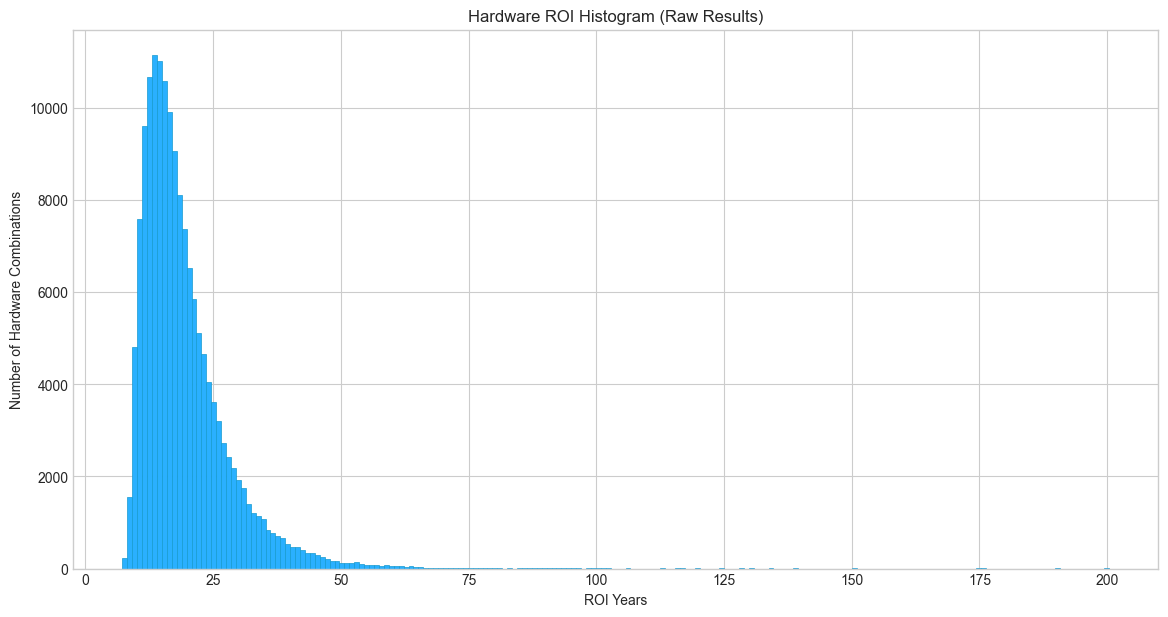

In [37]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(results_df['realRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware ROI Histogram (Raw Results)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Filtering

In [38]:
#filter out anything with an ROI over its working years
favROI_df = results_df[results_df['realRoi'] <= results_df['workingLife']] 

favROI_df_Z = favROI_df[favROI_df['immediateEventAmt'] == 0] 
favROI_df_O = favROI_df[favROI_df['immediateEventAmt'] == 1] 
favROI_df_F = favROI_df[favROI_df['immediateEventAmt'] == 5] 

print('Total Combinations')
print(str(favROI_df.shape[0])+ ' total favorable ROI hardware combinations generated')
print(str(favROI_df_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')

print('Eastern')
print(str(favROI_df[favROI_df['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Five Immediate Event')

print('Southern')
print(str(favROI_df[favROI_df['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Five Immediate Event')

print('Western')
print(str(favROI_df[favROI_df['az']==250].shape[0])+ ' westerm favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==250].shape[0])+ ' westerm favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==250].shape[0])+ ' westerm favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==250].shape[0])+ ' westerm favorable ROI hardware combinations generated - Five Immediate Event')

Total Combinations
3536 total favorable ROI hardware combinations generated
1199 total favorable ROI hardware combinations generated - Zero Immediate Event
1189 total favorable ROI hardware combinations generated - One Immediate Event
1148 total favorable ROI hardware combinations generated - Five Immediate Event
Eastern
799 eastern favorable ROI hardware combinations generated
267 eastern favorable ROI hardware combinations generated - Zero Immediate Event
267 eastern favorable ROI hardware combinations generated - One Immediate Event
265 eastern favorable ROI hardware combinations generated - Five Immediate Event
Southern
1886 southern favorable ROI hardware combinations generated
640 southern favorable ROI hardware combinations generated - Zero Immediate Event
634 southern favorable ROI hardware combinations generated - One Immediate Event
612 southern favorable ROI hardware combinations generated - Five Immediate Event
Western
851 westerm favorable ROI hardware combinations generat

In [39]:
#these should all match when inflation and degrade rates are set to 0
#p = 0
# print(favROI_df.iloc[p][['annualPVkWh','annualPVkWh_degraded']])
# print(favROI_df.iloc[p][['annualPVkWhAC','annualPVkWhAC_degraded']])
# print(favROI_df.iloc[p][['maxAutoParticipationMonthlyW','maxAutoParticipationMonthlyW_degraded']])
# print(favROI_df.iloc[p][['drIncMonthly','drIncMonthly_degraded']])
# print(favROI_df.iloc[p][['annualIncome','annualIncome_degInf']])

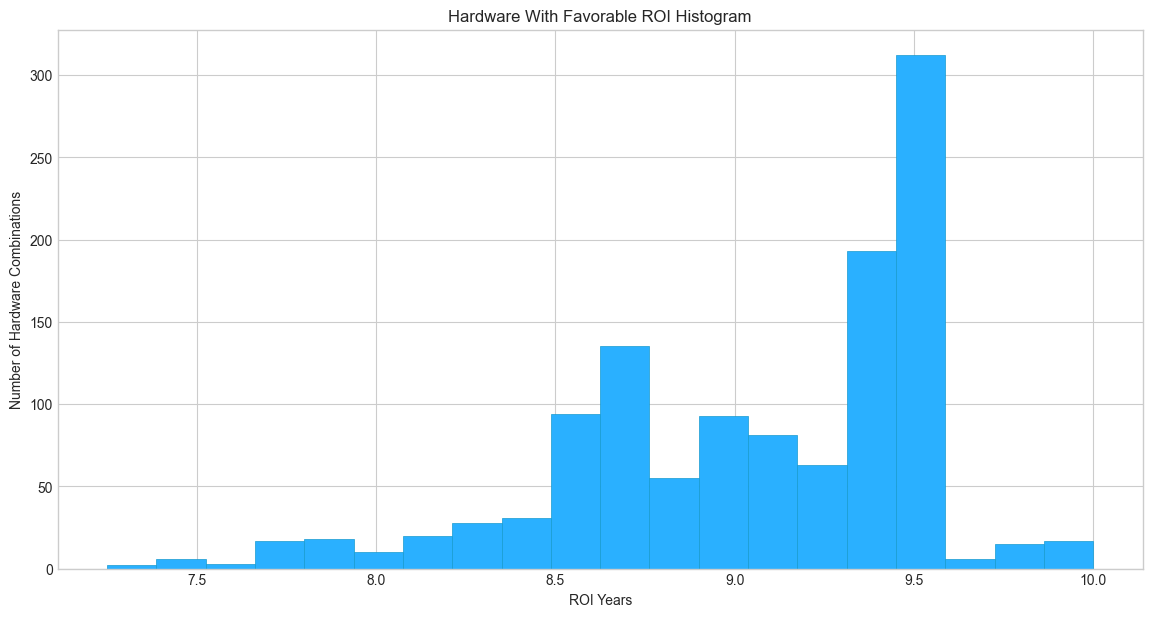

In [41]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['realRoi'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

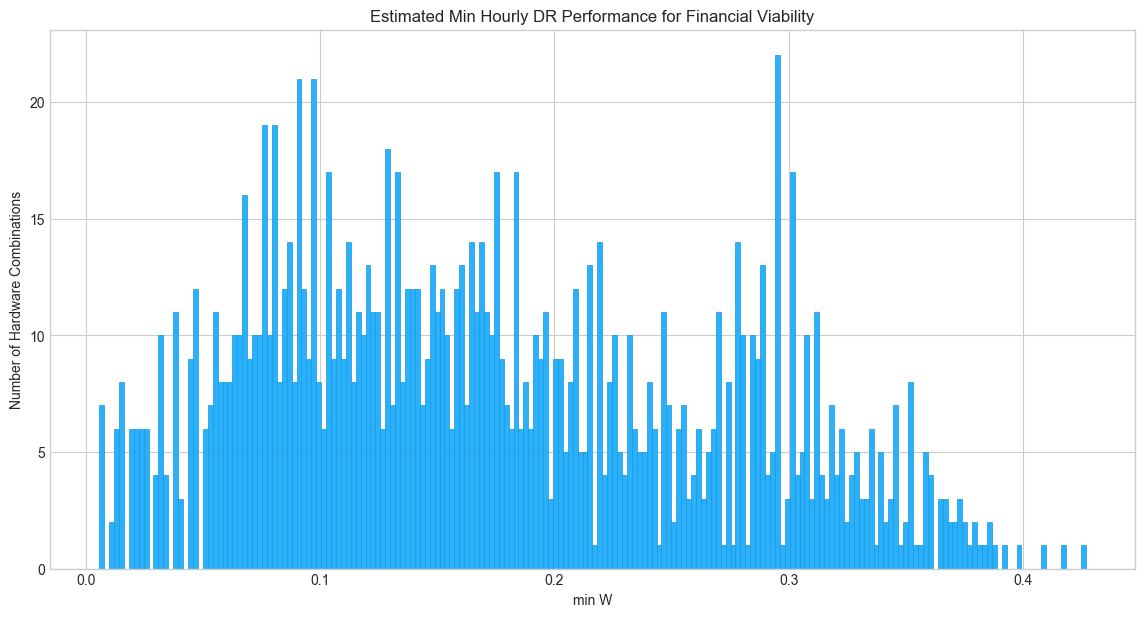

In [352]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['minDRkWperf'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Estimated Min Hourly DR Performance for Financial Viability') 
plt.xlabel('min W') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

# Analysis

To analize:
* impact of network characteristics
* time and overall quantity
* relationship between azimuth and time

## Overall - Zero Immediate Events

* Fastest ROI
* Greatest IAR
* Greatest DR impact
* Greatest PV generation DC
* Greatest avoided grid energy

In [353]:
# fastest ROI
fRoi = favROI_df_Z[favROI_df_Z['realRoi'] == min(favROI_df_Z['realRoi'])]
print("Fastest ROI: " + str(fRoi['realRoi'].iloc[0]) + "yrs")
# slowest ROI
sRoi = favROI_df_Z[favROI_df_Z['realRoi'] == max(favROI_df_Z['realRoi'])]
print("Slowest ROI: " + str(sRoi['realRoi'].iloc[0]) + "yrs")


Fastest ROI: 7.5yrs
Slowest ROI: 10.0yrs


Greatest IAR: $370.6887004768742 ($38.657535906874024/per year for 9.58904109589041 years)
Lowest IAR: $0.0 ($0.0/per year for 9.58904109589041 years)
Amount with 0 IAR: 179


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


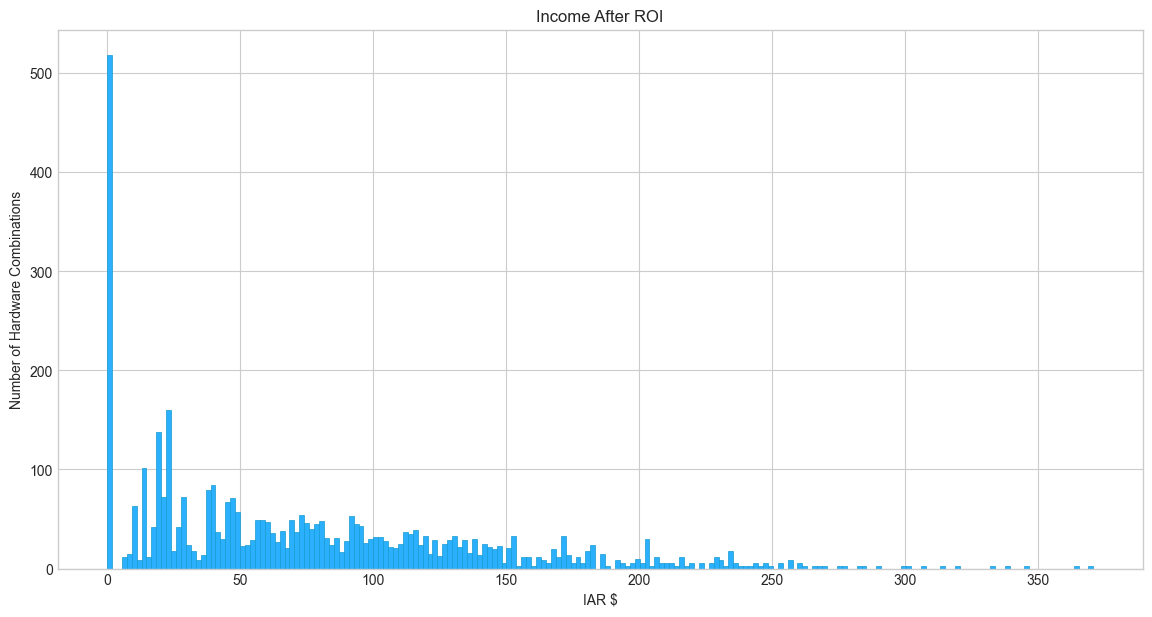

In [354]:
# Income After ROI
maxIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == max(favROI_df_Z['incomeAfterRoi'])]
print("Greatest IAR: $" + str(maxIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

minIAR = favROI_df_Z[favROI_df['incomeAfterRoi'] == min(favROI_df_Z['incomeAfterRoi'])]
print("Lowest IAR: $" + str(minIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

print('Amount with 0 IAR: ' + str(favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == 0].shape[0]))
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Income After ROI') 
plt.xlabel('IAR $') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware'}, xlabel='batWh', ylabel='pvW'>

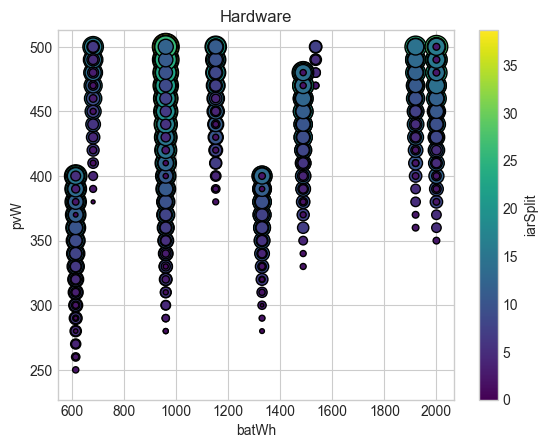

In [355]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware')


<AxesSubplot:title={'center':'Hardware w/ IAR >= $300'}, xlabel='batWh', ylabel='pvW'>

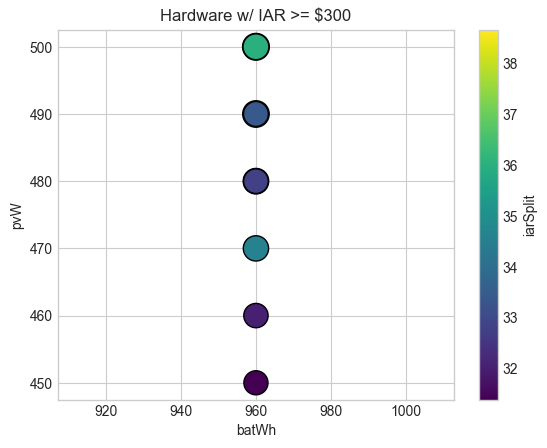

In [356]:
# High IAR

highIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] >= 300]

highIAR.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware w/ IAR >= $300')

# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(highIAR['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Income After ROI ($0 IAR not shown)') 
# plt.xlabel('IAR $') 
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


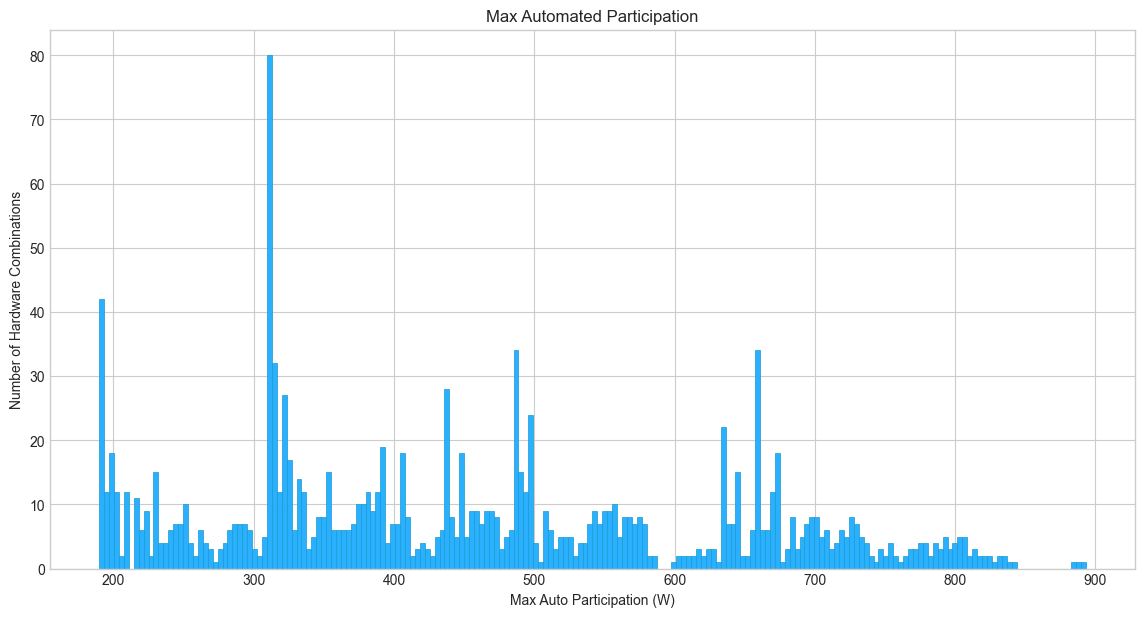

In [357]:
favROI_df_Z['avgMAPw'] = favROI_df_Z['avgMAPw_C'] + favROI_df_Z['avgMAPw_D']

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['avgMAPw'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Max Automated Participation') 
plt.xlabel('Max Auto Participation (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

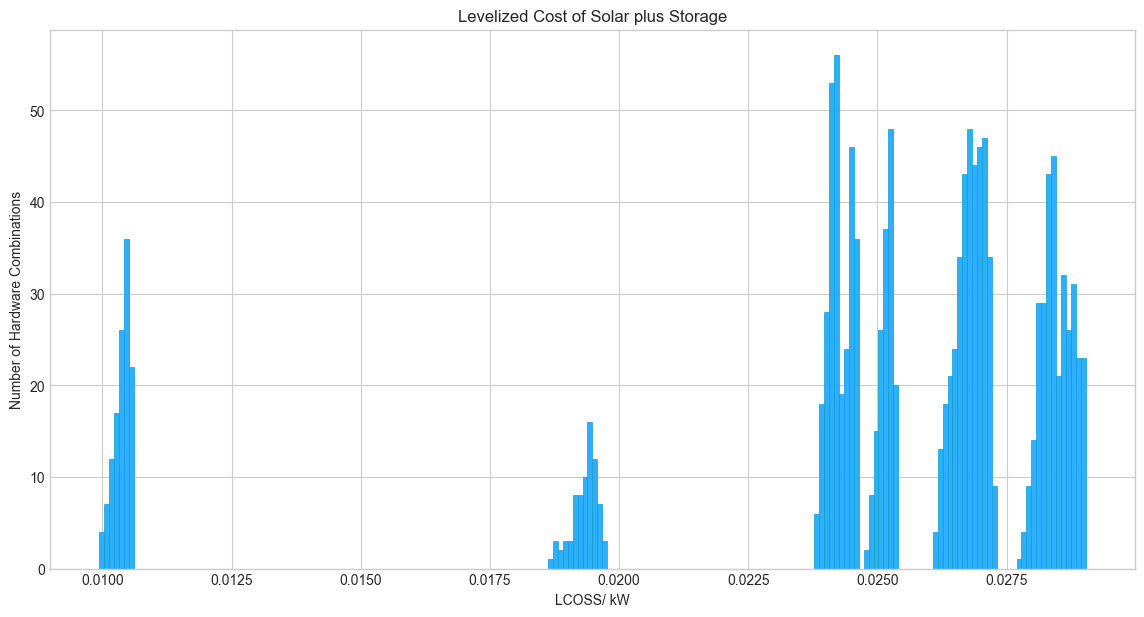

In [358]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['LCOSS'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Levelized Cost of Solar plus Storage') 
plt.xlabel('LCOSS/ kW') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [359]:
#levelized cost compaprison
#https://www.statista.com/statistics/493797/estimated-levelized-cost-of-energy-generation-in-the-us-by-technology/
#2023 commercial solar + store lcoe: $46-102/ per megawatts

print(46/1000)
print(102/1000)

0.046
0.102


## Impact of Network Characteristics

Below this point, only favorable ROI combinations are considered.

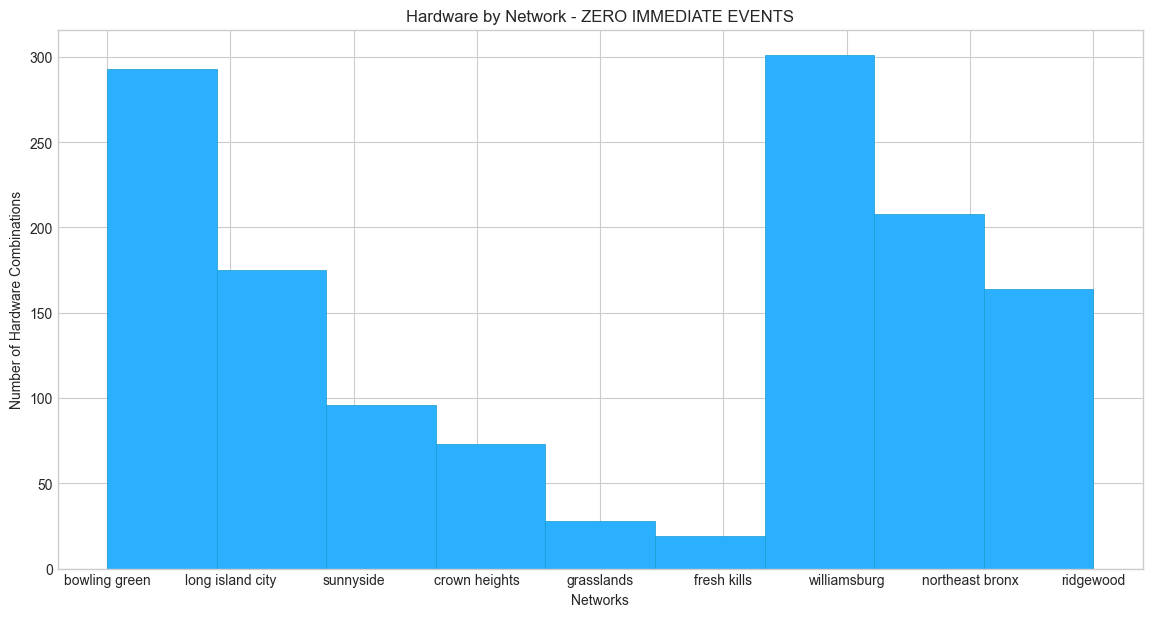

In [360]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware by Network - ZERO IMMEDIATE EVENTS') 
plt.xlabel('Networks') 
#plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [361]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_O['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - ONE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

In [362]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_F['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - FIVE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

<AxesSubplot:title={'center':'ROIs'}, xlabel='realRoi', ylabel='eventStart'>

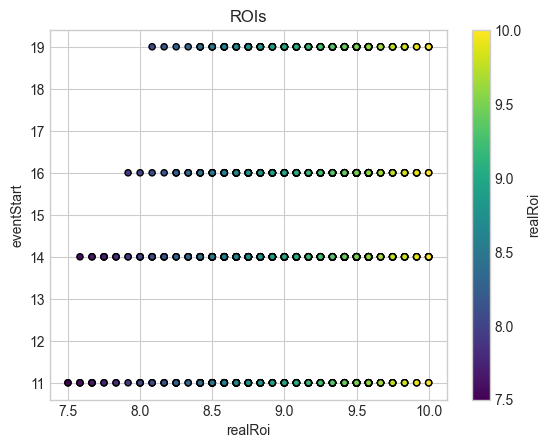

In [363]:
favROI_df_Z.plot(kind = 'scatter', x = 'realRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='ROIs')


In [364]:
#build a data frame with characteristics by neighborhood

#regardless of azimuth
nFavorable = {
    "name":[],
    "total amount":[],
    "start time":[],
    "dr rate $":[],
    "min PV":[],
    "min PV bat Wh":[], #the battery that pairs with the min PV module
    "max PV":[],
    "max PV bat Wh":[], #the battery that pairs with the max PV module
    "min bat":[],
    "min bat PV W":[], #the PV modules that pair with the min battery
    "max bat":[],
    "max bat PV W":[], #the PV modules that pair with the max battery
    "min capex":[],
    "max capex":[],
    #avg capex is kind of meaningless,
    #because lower call times have both cheaper and most expensive system,
    #so just a wider range of possibilities
    "avg capex":[], 
    "min ROI":[],
    "max ROI":[],
    "avg ROI":[],
    "min IAR":[],
    "max IAR":[],
    "avg IAR":[],
    "min DR":[],
    "max DR":[],
    "avg DR":[]
}
for n in myNetworks:
    tNAz = favROI_df_Z[favROI_df_Z['network'] == n]
    tN = tNAz#[tNAz['az'] == 180] #uncomment to filter by azimuth
    nFavorable['name'].append(n)
    
    nFavorable['start time'].append(getStartTime(n))
    nFavorable['dr rate $'].append(getTotalRate(n))
    
    if tN.shape[0] != 0:
        nFavorable['total amount'].append(tN.shape[0])
    
        #min PV
        tNminMax = tN[tN['pvW'] == min(tN['pvW'])]
        nFavorable['min PV'].append(min(tN['pvW']))
        nFavorable['min PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #max PV
        tNminMax = tN[tN['pvW'] == max(tN['pvW'])]
        nFavorable['max PV'].append(max(tN['pvW']))
        nFavorable['max PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #min BAT
        tNminMax = tN[tN['batWh'] == min(tN['batWh'])]
        nFavorable['min bat'].append(min(tN['batWh']))
        nFavorable['min bat PV W'].append(list(set(tNminMax['pvW'])))

        #max BAT
        tNminMax = tN[tN['batWh'] == max(tN['batWh'])]
        nFavorable['max bat'].append(max(tN['batWh']))
        nFavorable['max bat PV W'].append(list(set(tNminMax['pvW'])))

        nFavorable['min capex'].append(min(tN['capex']))
        nFavorable['max capex'].append(max(tN['capex']))
        nFavorable['avg capex'].append(tN['capex'].mean())
        nFavorable['min ROI'].append(min(tN['realRoi']))
        nFavorable['max ROI'].append(max(tN['realRoi']))
        nFavorable['avg ROI'].append(tN['realRoi'].mean())
        
        nFavorable['min IAR'].append(min(tN['incomeAfterRoi']))
        nFavorable['max IAR'].append(max(tN['incomeAfterRoi']))
        nFavorable['avg IAR'].append(tN['incomeAfterRoi'].mean())

        mDR = []
        for y in range(len(tN['maxAutoParticipationW_C'])):
            #print(list(tN['maxAutoParticipationW_C']))
            yC = sum(list(tN['maxAutoParticipationW_C'])[y])
            yD = sum(list(tN['maxAutoParticipationW_D'])[y])
            mDR.append(sum([yC,yD])/len(list(tN['maxAutoParticipationW_C'])[y]))

        nFavorable['min DR'].append(min(mDR))
        nFavorable['max DR'].append(max(mDR))
        nFavorable['avg DR'].append(sum(mDR)/len(mDR))
    else:
        for k in ['total amount','min PV','min PV bat Wh','max PV','max PV bat Wh',
                  'min bat','min bat PV W','max bat','max bat PV W',
                  'min capex','max capex','avg capex','min ROI','max ROI',
                  'avg ROI','min IAR','max IAR','avg IAR','min DR','max DR','avg DR']:
            nFavorable[k].append(0)

networkResults_df = pd.DataFrame.from_dict(nFavorable)
networkResults_df

,name,total amount,start time,dr rate $,min PV,min PV bat Wh,max PV,max PV bat Wh,min bat,min bat PV W,...,avg capex,min ROI,max ROI,avg ROI,min IAR,max IAR,avg IAR,min DR,max DR,avg DR
0,bowling green,293,11,36,240,[614.0],500,"[1536.0, 1152.0, 1920.0, 1440.0, 960.0, 680.96...",614.0,"[320, 290, 260, 390, 360, 330, 300, 270, 400, ...",...,1344.463300,7.500000,10.000000,9.030432,0.0,370.688700,97.510895,271.364334,892.979032,546.084284
1,long island city,175,14,36,270,[614.0],500,"[1152.0, 1920.0, 960.0, 680.96, 2000.0]",614.0,"[320, 290, 390, 360, 330, 300, 270, 400, 370, ...",...,1298.578566,7.750000,10.000000,9.162381,0.0,298.496748,72.747513,217.514956,756.769489,444.528641
2,sunnyside,96,16,36,300,[614.0],500,"[1152.0, 1920.0, 960.0, 680.96, 2000.0]",614.0,"[320, 390, 360, 330, 300, 400, 370, 340, 310, ...",...,1250.124979,8.250000,9.916667,9.244792,0.0,223.365075,56.752314,193.611723,673.916220,361.417335
3,crown heights,73,19,36,310,[614.0],500,"[1152.0, 1920.0, 960.0, 680.96, 2000.0]",614.0,"[320, 390, 360, 330, 400, 370, 340, 310, 380, ...",...,1248.219511,8.416667,10.000000,9.302511,0.0,191.507282,47.258696,189.878184,660.515207,345.959223
4,grasslands,28,14,24,330,[614.0],500,"[680.96, 960.0]",614.0,"[390, 360, 330, 400, 370, 340, 380, 350]",...,1122.379932,8.666667,10.000000,9.261905,0.0,137.352671,45.162549,224.736396,410.495484,329.345591
5,fresh kills,19,16,24,350,[614.0],500,[960.0],614.0,"[390, 360, 400, 370, 380, 350]",...,1129.548901,8.750000,9.583333,9.271930,0.0,121.002768,42.621209,199.755394,336.814520,284.652647
6,williamsburg,301,14,43,250,[614.0],500,"[1536.0, 1152.0, 1920.0, 1440.0, 960.0, 680.96...",614.0,"[320, 290, 260, 390, 360, 330, 300, 270, 400, ...",...,1367.307990,7.583333,10.000000,9.075028,0.0,345.130714,92.386513,215.461993,780.103431,490.359716
7,northeast bronx,208,16,43,270,[614.0],500,"[1536.0, 1152.0, 1920.0, 960.0, 680.96, 2000.0]",614.0,"[320, 290, 390, 360, 330, 300, 270, 400, 370, ...",...,1346.986216,7.916667,10.000000,9.212340,0.0,275.151851,67.526513,193.077932,685.456172,434.477354
8,ridgewood,164,19,43,290,[614.0],500,"[1152.0, 1920.0, 960.0, 680.96, 2000.0]",614.0,"[320, 290, 390, 360, 330, 300, 400, 370, 340, ...",...,1343.666473,8.083333,10.000000,9.253557,0.0,249.019357,60.383157,189.878184,660.515207,418.765440


In [365]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

# bPD = favROI_df[favROI_df['az'] == 250]
    
# boxPlotData = {}
# for n in myNetworks:
#     bP = bPD[bPD['network'] == n]
#     #print(bP['maxAutoParticipationW'].head())
#     #the full label thing doesn't work when some results are 0
#     #print(type(list(bP['maxAutoParticipationW'])))
#     boxPlotData[n]=bP['maxAutoParticipationW']# + "\n("+ str(bP.iloc[0]['eventStart']) + ", $" + str(bP.iloc[0]['totalDRratekW']) +")"]=bP['maxAutoParticipationW']

# boxPlot_df = pd.DataFrame.from_dict(boxPlotData)
# boxPlot_df.boxplot(figsize=(14,7))

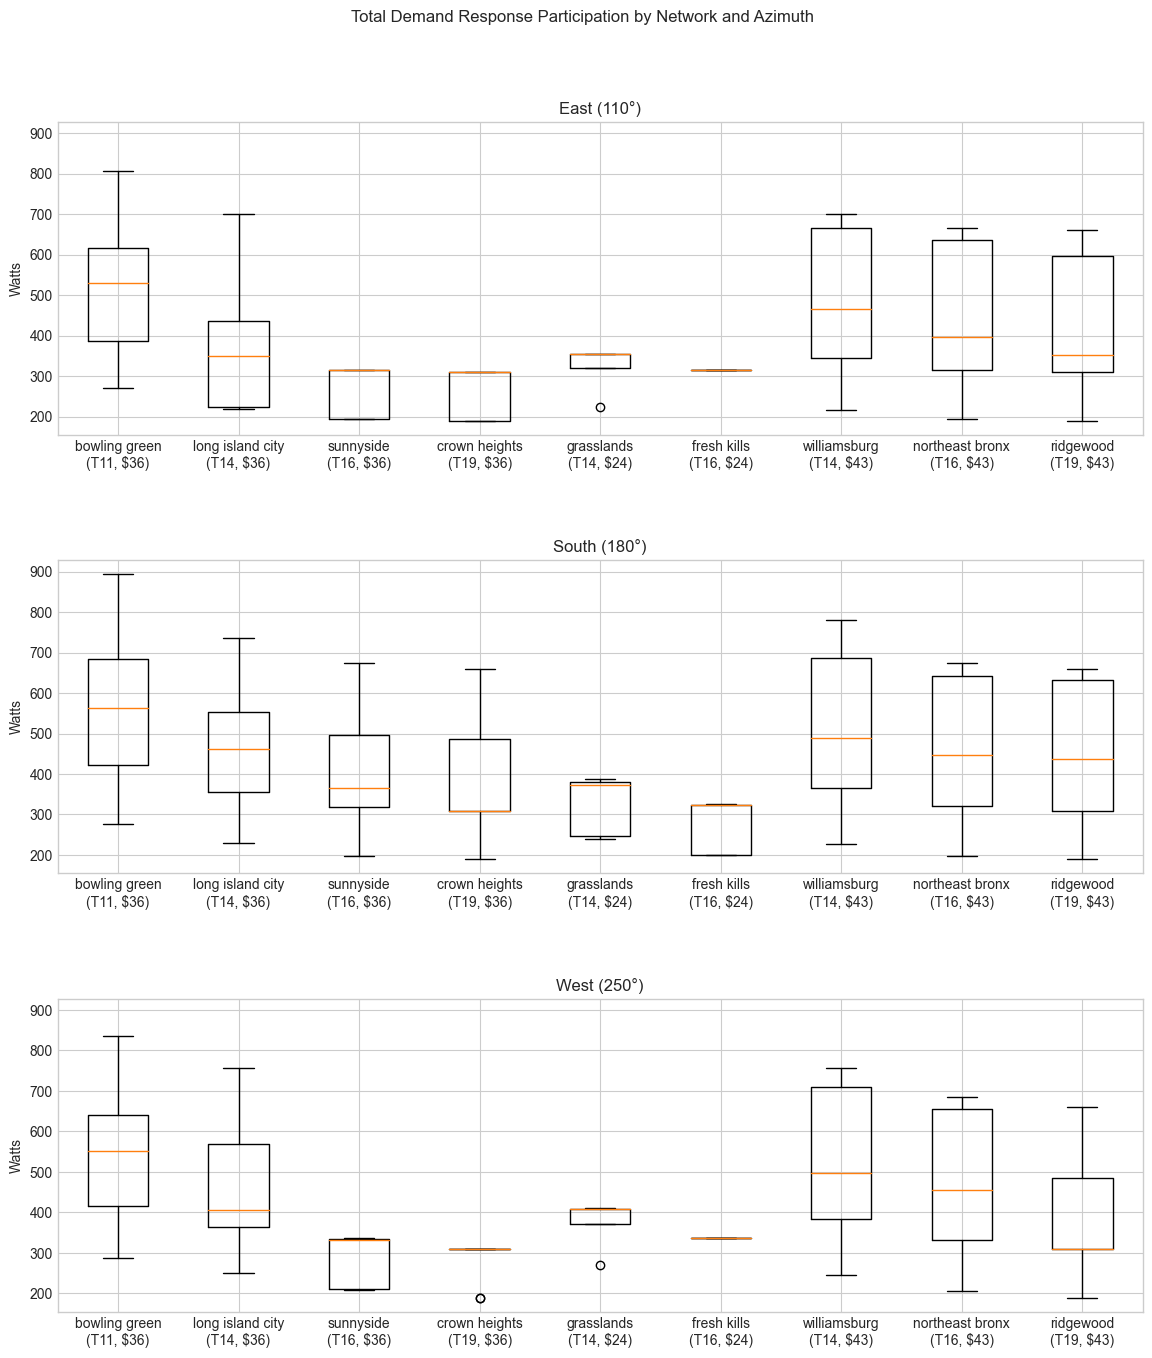

In [366]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_C'] + bP['avgMAPw_D']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('Total Demand Response Participation by Network and Azimuth')
    
plt.show()

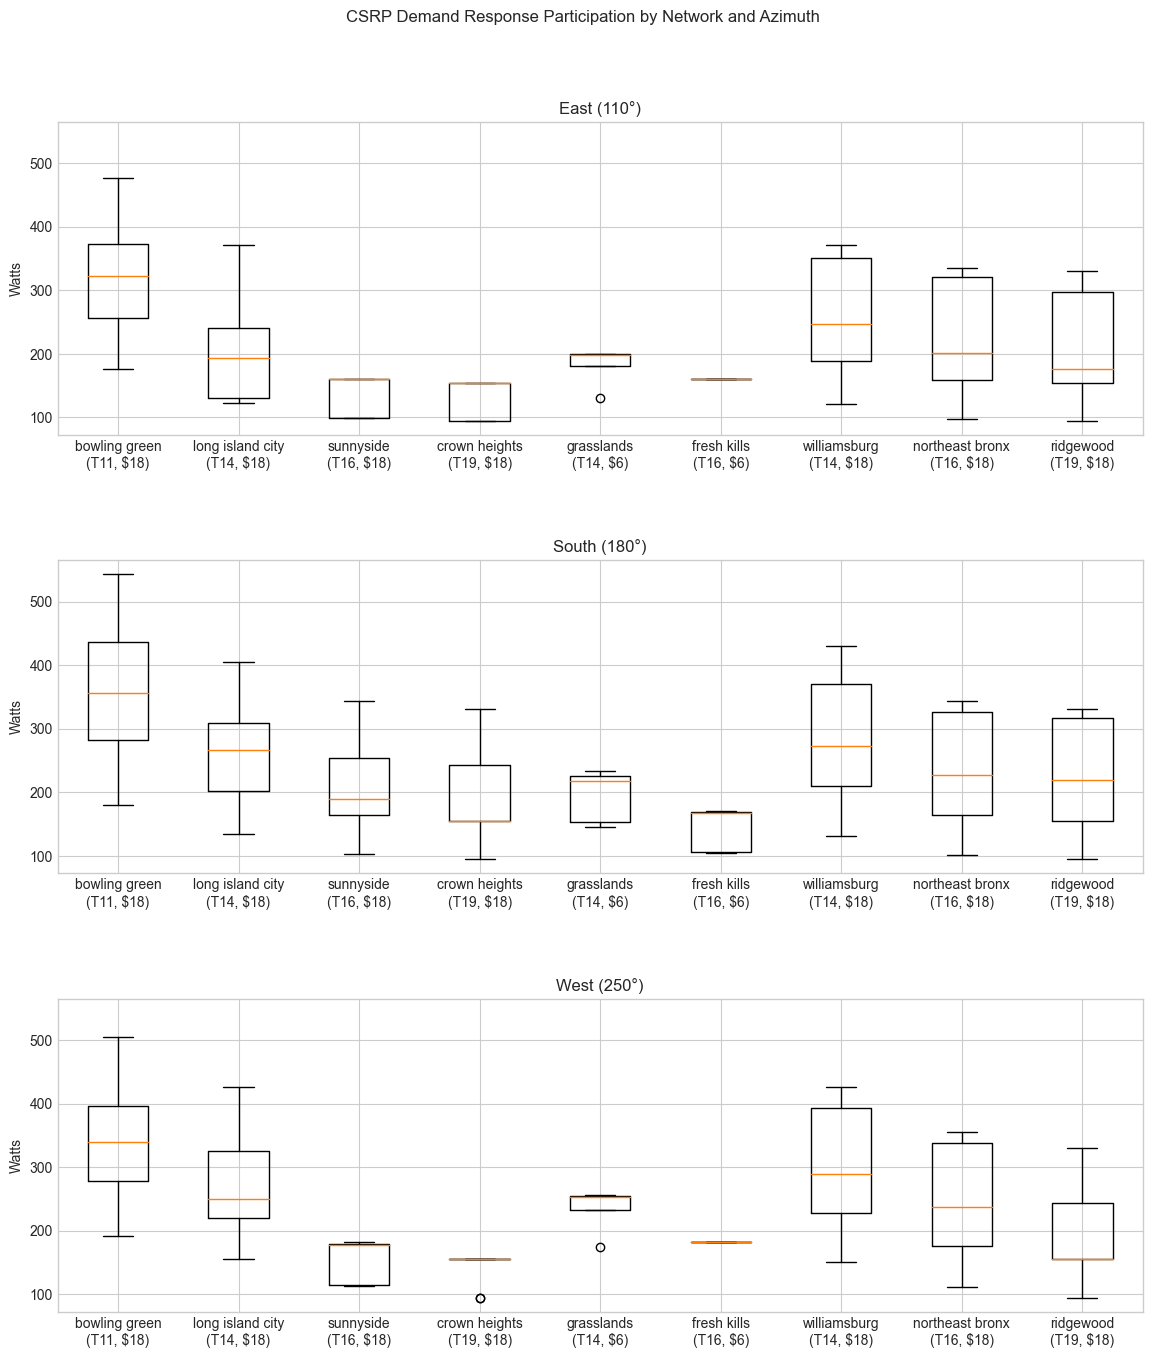

In [367]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getCSRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_C']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('CSRP Demand Response Participation by Network and Azimuth')
    
plt.show()


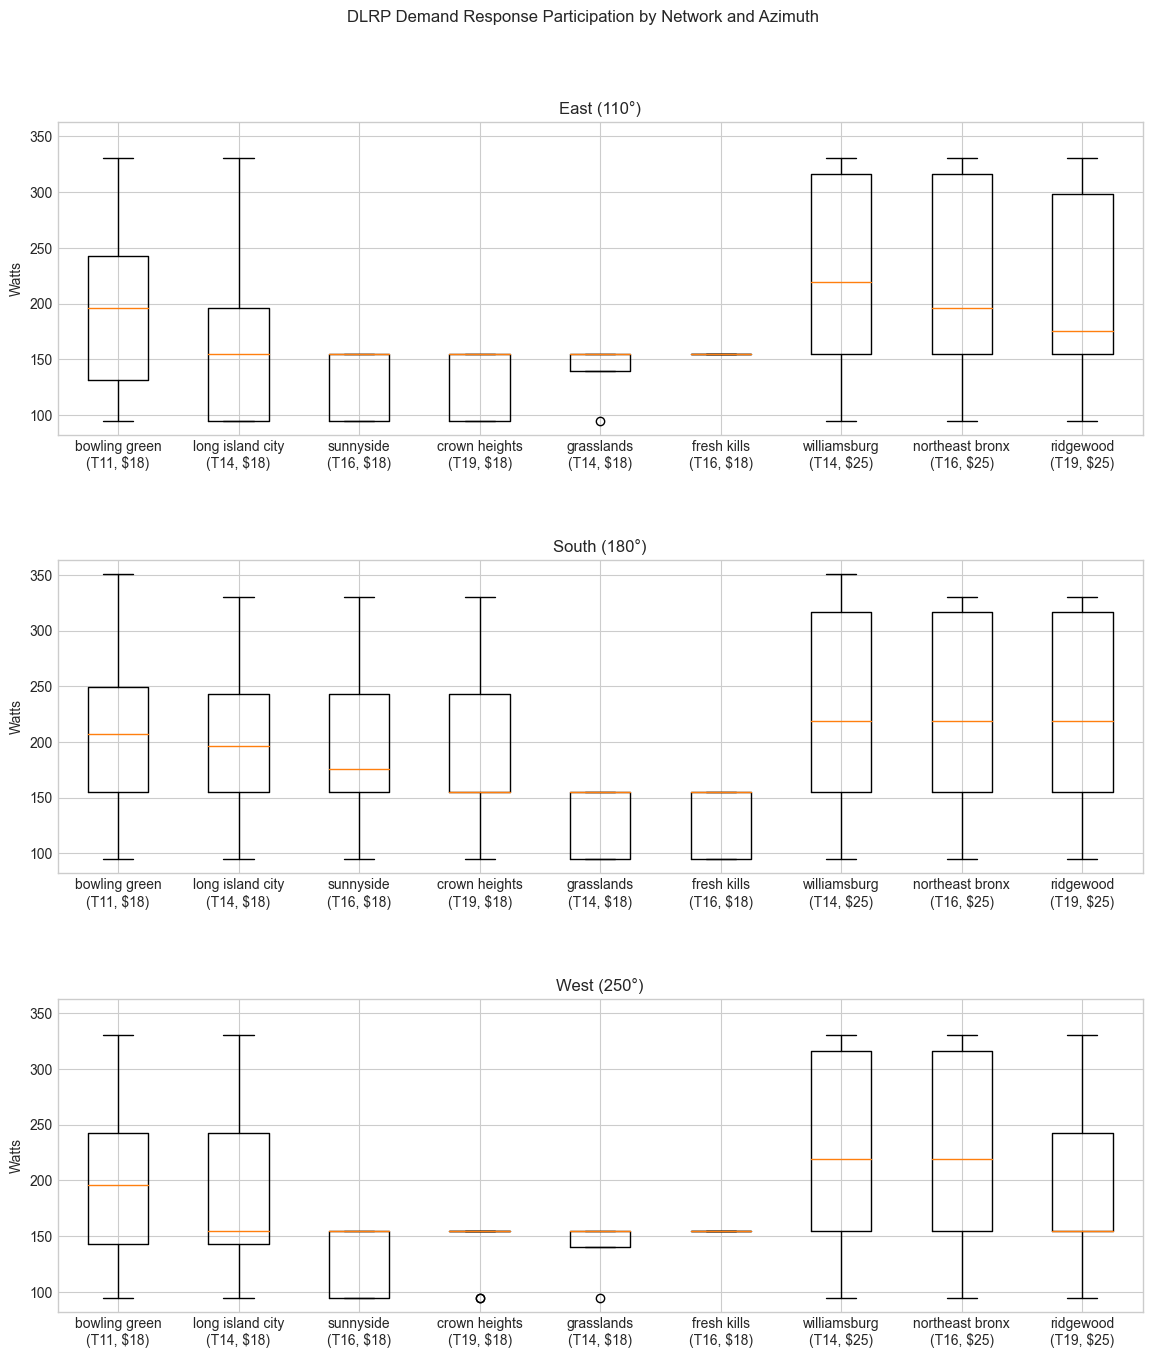

In [368]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getDLRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_D']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('DLRP Demand Response Participation by Network and Azimuth')
    
plt.show()


<AxesSubplot:title={'center':'Max Auto Participation CSRP'}, xlabel='avgMAPw_C', ylabel='eventStart'>

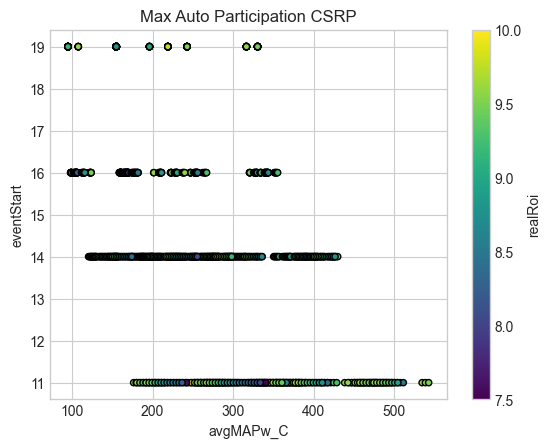

In [369]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_C', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation CSRP')


<AxesSubplot:title={'center':'Max Auto Participation DLRP'}, xlabel='avgMAPw_D', ylabel='eventStart'>

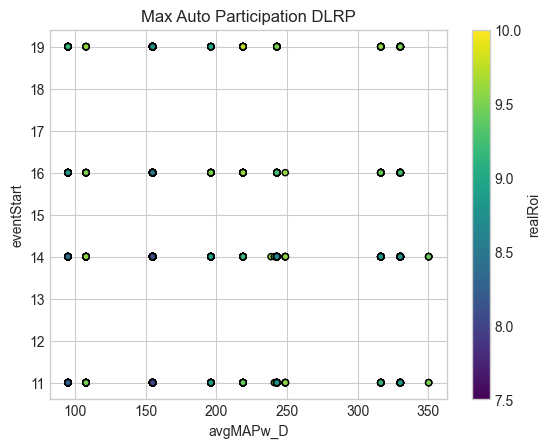

In [370]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_D', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation DLRP')


<AxesSubplot:title={'center':'Income After ROI'}, xlabel='incomeAfterRoi', ylabel='eventStart'>

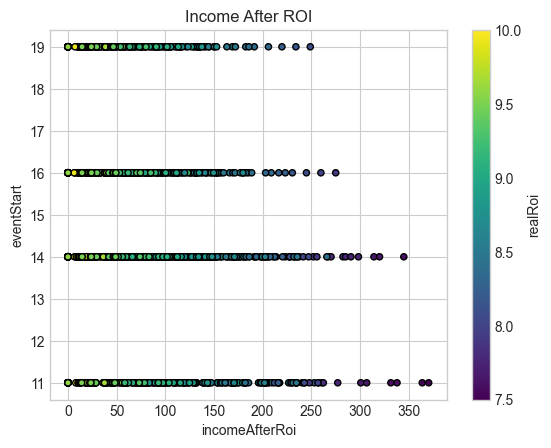

In [371]:
favROI_df_Z.plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Income After ROI')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

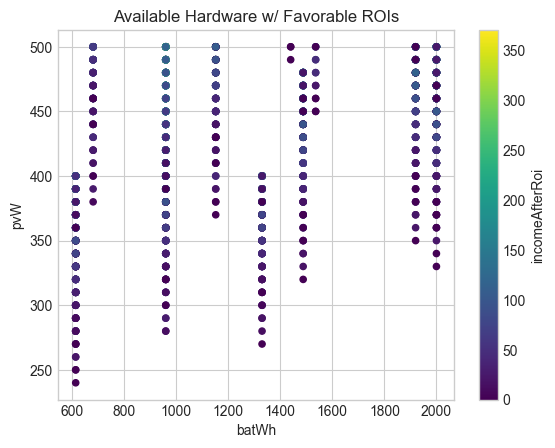

In [372]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs & high IAR'}, xlabel='batWh', ylabel='pvW'>

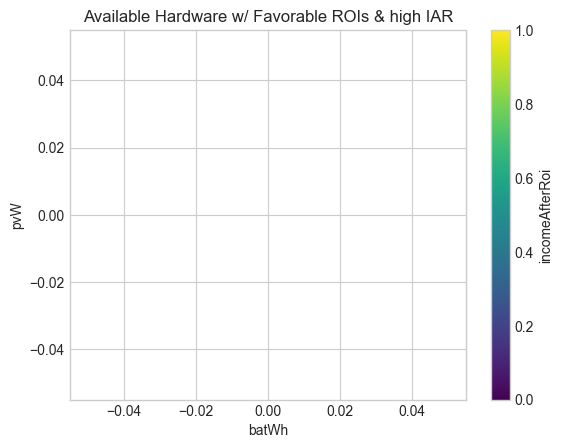

In [373]:
favROI_df_Z[favROI_df_Z['incomeAfterRoi']>=400].plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs & high IAR')


<AxesSubplot:title={'center':'Relationship between IAR and CSRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_C'>

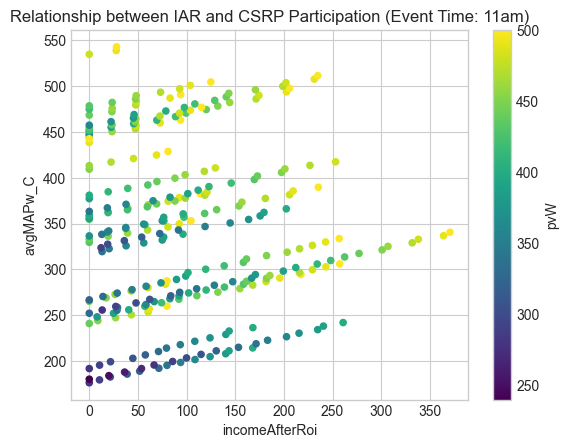

In [374]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_C', c='pvW',colormap='viridis', title='Relationship between IAR and CSRP Participation (Event Time: 11am)')


In [55]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_D', c='pvW',colormap='viridis', title='Relationship between IAR and DLRP Participation (Event Time: 11am)')


In [54]:
highParticipation_df = favROI_df_Z[favROI_df_Z['avgMAPw_C']>=400]
highParticipation_df.shape[0]

In [53]:
highParticipation_df.plot(kind = 'scatter', x = 'avgMAPw', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto CSRP Participation > 400W')


In [52]:
highParticipation_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='avgMAPw_C',s='avgMAPw',edgecolor='black',colormap='viridis', title='Available Hardware w/ CSRP Impact > 400W')
